# SPH Fluid Simulation Example

This notebook demonstrates how to set up and run a stable SPH (Smoothed Particle Hydrodynamics) simulation using `gravhydro`.

## Key Requirements for Stability

1. **CFL Condition**: $\Delta t < \frac{h}{c_s}$ where $h$ is the smoothing length and $c_s$ is the sound speed
2. **Consistent Units**: All quantities must use compatible units
3. **Kernel Support**: Particles must be within $2h$ of each other to interact
4. **Reference Density**: Should match the actual fluid density for the pressure equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import gravhydro as gh

# For animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Example 1: Dam Break (2D)

A classic SPH test case where a column of fluid collapses under its own pressure gradients.

In [2]:
# ============== SIMULATION PARAMETERS ==============
# These are the key parameters you need to tune

# Smoothing length - determines particle interaction radius (2h)
h = 0.5

# Sound speed - controls pressure wave propagation
# Lower values = more compressible, easier to simulate
# Higher values = more incompressible, requires smaller dt
cs = 20.0  # m/s (much lower than real water's 1402 m/s for stability)

# Timestep - MUST satisfy CFL condition: dt < h/cs
dt_max = h / cs
print(f"Maximum stable timestep (CFL): dt < {dt_max:.4f} s")

# Use a safety factor of 0.2-0.4 for the CFL condition
dt = 0.25 * dt_max
print(f"Using dt = {dt:.4f} s (CFL factor = 0.25)")

# Reference density - should match your initial particle density
rho0 = 1.0  # kg/m³ (we'll calculate actual density from particle setup)

Maximum stable timestep (CFL): dt < 0.0250 s
Using dt = 0.0063 s (CFL factor = 0.25)


In [3]:
# ============== PARTICLE SETUP ==============
# Create a rectangular block of particles (dam)

# Particle spacing - should be less than h for good kernel overlap
# Rule of thumb: spacing ~ h/2 gives ~4 neighbors per dimension
spacing = h / 2

# Dam dimensions
dam_width = 3.0   # x-direction
dam_height = 4.0  # y-direction

# Create regular grid
x = np.arange(0, dam_width, spacing)
y = np.arange(0, dam_height, spacing)
xx, yy = np.meshgrid(x, y)

# Flatten to particle positions (2D -> add z=0 for 3D)
pos_2d = np.column_stack([xx.ravel(), yy.ravel()])
pos = np.zeros((len(pos_2d), 3))
pos[:, :2] = pos_2d

n_particles = len(pos)
print(f"Number of particles: {n_particles}")
print(f"Particle spacing: {spacing} (kernel support radius: {2*h})")
print(f"Expected neighbors per particle: ~{np.pi * (2*h/spacing)**2:.0f} (2D)")

# Initialize velocities to zero
vel = np.zeros_like(pos)

# Set particle masses
# For uniform density: mass = rho0 * volume_per_particle
volume_per_particle = spacing**2  # 2D area (we're doing quasi-2D)
masses = np.ones(n_particles) * rho0 * volume_per_particle

print(f"Particle mass: {masses[0]:.4f} kg")

Number of particles: 192
Particle spacing: 0.25 (kernel support radius: 1.0)
Expected neighbors per particle: ~50 (2D)
Particle mass: 0.0625 kg


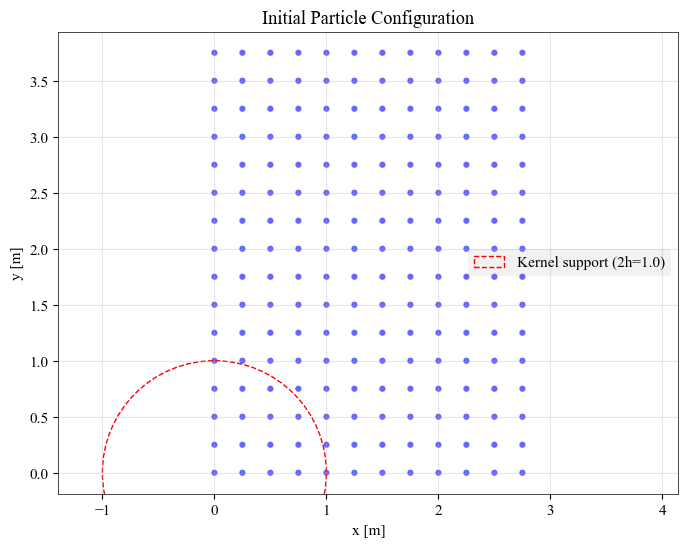

In [4]:
# Visualize initial setup
plt.figure(figsize=(8, 6))
plt.scatter(pos[:, 0], pos[:, 1], s=20, c='blue', alpha=0.6)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Initial Particle Configuration')
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Show kernel support radius
circle = plt.Circle((pos[0, 0], pos[0, 1]), 2*h, fill=False, color='red', 
                     linestyle='--', label=f'Kernel support (2h={2*h})')
plt.gca().add_patch(circle)
plt.legend()
plt.show()

In [5]:
# ============== RUN SIMULATION ==============
# Set up time array
t_end = 0.5  # total simulation time in seconds
n_steps = int(t_end / dt)
ts = np.linspace(0, t_end, n_steps + 1) * u.s

print(f"Running simulation:")
print(f"  Total time: {t_end} s")
print(f"  Number of timesteps: {n_steps}")
print(f"  dt = {dt:.4f} s")

# Convert to astropy units
pos_units = pos * u.m
vel_units = vel * u.m / u.s  # IMPORTANT: use m/s, not km/s!
mass_units = masses * u.kg
cs_units = cs * u.m / u.s
rho0_units = rho0 * u.kg / u.m**3  # 3D density units

# Create and run simulation
sim = gh.Simulation()
sim.run(
    pos_units, 
    vel_units, 
    mass_units, 
    ts,
    h=h,
    cs=cs_units, 
    rho0=rho0_units,
    hydroOnly=True,      # Only hydrodynamics, no gravity
    gravityOnly=False,
    use_numba=True
)

Running simulation:
  Total time: 0.5 s
  Number of timesteps: 80
  dt = 0.0063 s


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 80/80 [00:02<00:00, 35.62it/s]


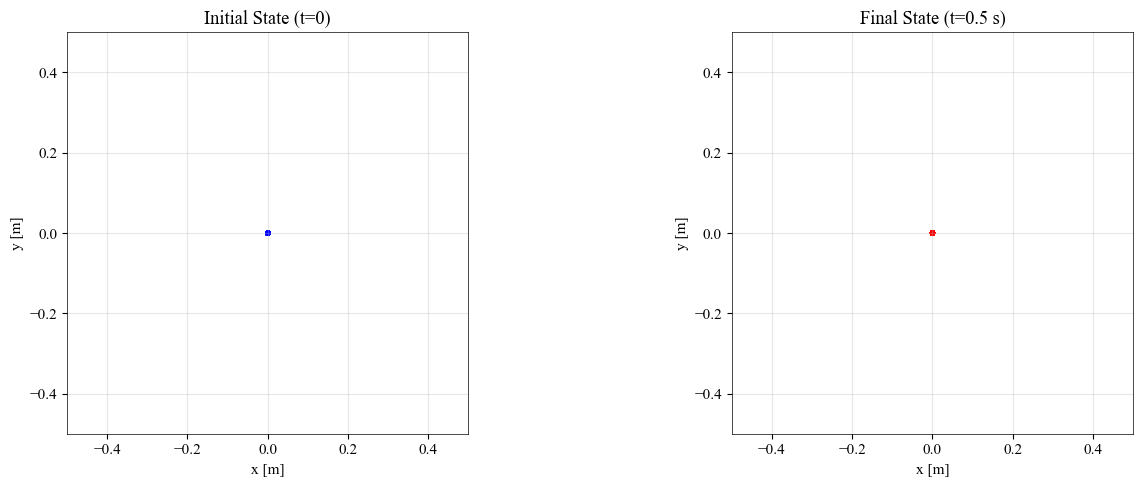

In [6]:
# ============== VISUALIZE RESULTS ==============
# Plot initial vs final state
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Initial state
axes[0].scatter(sim.positions[0, :, 0], sim.positions[0, :, 1], s=15, c='blue', alpha=0.6)
axes[0].set_xlabel('x [m]')
axes[0].set_ylabel('y [m]')
axes[0].set_title('Initial State (t=0)')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Final state
axes[1].scatter(sim.positions[-1, :, 0], sim.positions[-1, :, 1], s=15, c='red', alpha=0.6)
axes[1].set_xlabel('x [m]')
axes[1].set_ylabel('y [m]')
axes[1].set_title(f'Final State (t={t_end} s)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Match axes limits
all_x = np.concatenate([sim.positions[0, :, 0].value, sim.positions[-1, :, 0].value])
all_y = np.concatenate([sim.positions[0, :, 1].value, sim.positions[-1, :, 1].value])
for ax in axes:
    ax.set_xlim(all_x.min() - 0.5, all_x.max() + 0.5)
    ax.set_ylim(all_y.min() - 0.5, all_y.max() + 0.5)

plt.tight_layout()
plt.show()

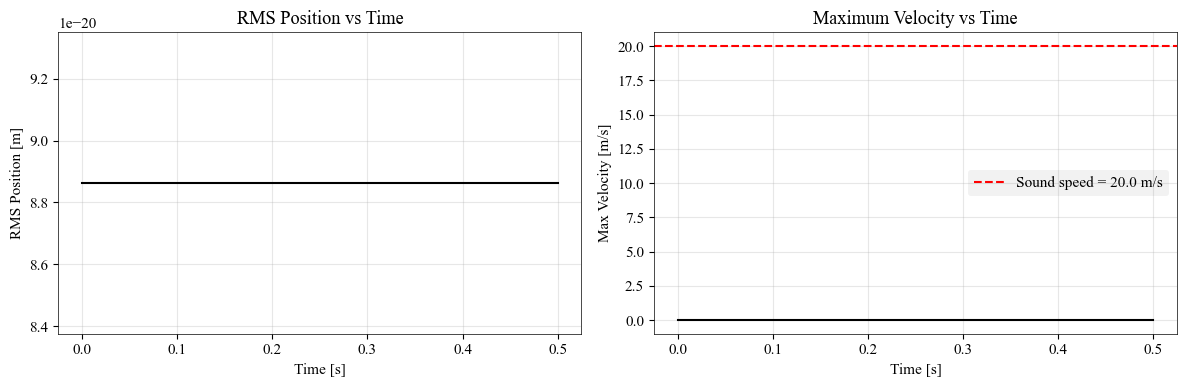

✓ Simulation appears stable (velocities within reasonable bounds)


In [7]:
# ============== CHECK STABILITY ==============
# Plot position statistics over time to verify no explosion

# Calculate RMS position at each timestep
rms_pos = np.sqrt(np.mean(sim.positions[:, :, 0]**2 + sim.positions[:, :, 1]**2, axis=1))

# Calculate max velocity at each timestep
max_vel = np.max(np.sqrt(sim.velocities[:, :, 0]**2 + sim.velocities[:, :, 1]**2), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ts.value, rms_pos.value)
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('RMS Position [m]')
axes[0].set_title('RMS Position vs Time')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ts.value, max_vel.value)
axes[1].axhline(cs, color='r', linestyle='--', label=f'Sound speed = {cs} m/s')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Max Velocity [m/s]')
axes[1].set_title('Maximum Velocity vs Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if simulation exploded
if max_vel[-1].value > 10 * cs:
    print("⚠️ WARNING: Velocities exceed 10x sound speed - simulation may be unstable!")
else:
    print("✓ Simulation appears stable (velocities within reasonable bounds)")

In [8]:
# ============== ANIMATION (Optional) ==============
# Create an animation of the simulation

fig, ax = plt.subplots(figsize=(8, 6))

# Set up fixed axis limits
all_positions = sim.positions.value
x_min, x_max = all_positions[:, :, 0].min() - 0.5, all_positions[:, :, 0].max() + 0.5
y_min, y_max = all_positions[:, :, 1].min() - 0.5, all_positions[:, :, 1].max() + 0.5

scatter = ax.scatter([], [], s=15, c='blue', alpha=0.6)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

def init():
    scatter.set_offsets(np.empty((0, 2)))
    time_text.set_text('')
    return scatter, time_text

def animate(frame):
    # Skip frames for faster animation
    i = frame * max(1, len(ts) // 100)
    if i >= len(ts):
        i = len(ts) - 1
    
    positions = np.column_stack([sim.positions[i, :, 0].value, 
                                  sim.positions[i, :, 1].value])
    scatter.set_offsets(positions)
    time_text.set_text(f't = {ts[i].value:.3f} s')
    return scatter, time_text

n_frames = min(100, len(ts))
anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, 
                     interval=50, blit=True)

plt.close()  # Prevent static display
HTML(anim.to_jshtml())

## Tips for Stable Simulations

### Parameter Guidelines

| Parameter | Typical Range | Notes |
|-----------|---------------|-------|
| `h` (smoothing length) | 1-2× particle spacing | Determines interaction radius |
| `cs` (sound speed) | 10× max expected velocity | Lower = more stable but more compressible |
| `dt` (timestep) | 0.1-0.4 × h/cs | Must satisfy CFL condition |
| `rho0` (reference density) | Match initial setup | Affects pressure calculation |

### Common Issues and Solutions

1. **Particles flying apart**: `dt` too large, reduce it
2. **Particles clumping**: Negative pressures, check `rho0` matches actual density
3. **No particle motion**: Kernel support too small, increase `h` or decrease spacing
4. **Very slow simulation**: `cs` too high, try reducing it (makes fluid more compressible)

In [9]:
# ============== DIAGNOSE THE ISSUE ==============
# Let's check why particles aren't moving

import sys
# Force reimport of gravhydro modules
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

from gravhydro.hydro import densities, pressureAcc
from gravhydro.hydro.pressure import pressure
from gravhydro.hydro.kernel import W, dWdr, gradW

# Check kernel values at typical separations
print("=== KERNEL DIAGNOSTICS ===")
print(f"h = {h}, kernel support = 2h = {2*h}")
print(f"Particle spacing = {spacing}")

# Test separations
r_tests = np.array([0.0, spacing, 2*spacing, h, 2*h, 3*h])
for r in r_tests:
    w_val = W(np.array([r]), h, ndim=3)[0]
    print(f"  W(r={r:.2f}, h={h}) = {w_val:.4f}")

# Check actual particle separations
print("\n=== PARTICLE SEPARATION CHECK ===")
dists = []
for i in range(min(10, len(pos))):
    for j in range(i+1, min(10, len(pos))):
        d = np.linalg.norm(pos[i] - pos[j])
        dists.append(d)
dists = np.array(dists)
print(f"Min separation: {dists.min():.4f}")
print(f"Max separation (first 10 particles): {dists.max():.4f}")
print(f"Mean separation: {dists.mean():.4f}")

# Check densities
print("\n=== DENSITY CHECK ===")
dens = densities(pos, masses, h)
print(f"Density range: {dens.min():.6f} to {dens.max():.6f}")
print(f"Mean density: {dens.mean():.6f}")
print(f"Reference density (rho0): {rho0}")

# Check pressures
print("\n=== PRESSURE CHECK ===")
P = pressure(dens, rho0, cs)
print(f"Pressure range: {P.min():.6f} to {P.max():.6f}")

# Check accelerations
print("\n=== ACCELERATION CHECK ===")
acc = pressureAcc(pos, masses, h, rho0, cs)
print(f"Acceleration magnitude range: {np.linalg.norm(acc, axis=1).min():.6e} to {np.linalg.norm(acc, axis=1).max():.6e}")
print(f"Max acceleration: {acc.max():.6e}")

=== KERNEL DIAGNOSTICS ===
h = 0.5, kernel support = 2h = 1.0
Particle spacing = 0.25
  W(r=0.00, h=0.5) = 2.5465
  W(r=0.25, h=0.5) = 1.8303
  W(r=0.50, h=0.5) = 0.6366
  W(r=0.50, h=0.5) = 0.6366
  W(r=1.00, h=0.5) = 0.0000
  W(r=1.50, h=0.5) = 0.0000

=== PARTICLE SEPARATION CHECK ===
Min separation: 0.2500
Max separation (first 10 particles): 2.2500
Mean separation: 0.9167

=== DENSITY CHECK ===
Density range: 0.628506 to 1.399941
Mean density: 1.231464
Reference density (rho0): 1.0

=== PRESSURE CHECK ===
Pressure range: 0.000000 to 545.041319

=== ACCELERATION CHECK ===
Acceleration magnitude range: 1.934333e+02 to 9.764340e+04
Max acceleration: 9.764340e+04


In [10]:
# ============== THE REAL ISSUE: UNIT SYSTEM ==============
# The gravhydro package uses GALACTIC units internally!
# L_UNIT = 100 pc, M_UNIT = 10^4 Msun

from gravhydro.utils.units import L_UNIT, M_UNIT, t_UNIT, convert_to_internal

print("=== GRAVHYDRO INTERNAL UNIT SYSTEM ===")
print(f"Length unit: {L_UNIT}")
print(f"Mass unit: {M_UNIT}")
print(f"Time unit: {t_UNIT}")
print(f"Velocity unit: {(L_UNIT/t_UNIT).to(u.km/u.s)}")
print(f"Density unit: {(M_UNIT/L_UNIT**3).to(u.kg/u.m**3)}")

print("\n=== WHAT HAPPENS TO YOUR SI VALUES ===")
print(f"1 meter in internal units: {convert_to_internal(1*u.m):.2e}")
print(f"1 kg in internal units: {convert_to_internal(1*u.kg):.2e}")
print(f"1 second in internal units: {convert_to_internal(1*u.s):.2e}")
print(f"1 m/s in internal units: {convert_to_internal(1*u.m/u.s):.2e}")
print(f"1 kg/m^3 in internal units: {convert_to_internal(1*u.kg/u.m**3):.2e}")

print("\n=== THIS IS WHY NOTHING MOVES! ===")
print("Your 1 meter becomes ~3e-20 internal length units!")
print("The simulation is essentially working with infinitesimal distances.")

=== GRAVHYDRO INTERNAL UNIT SYSTEM ===
Length unit: 100.0 pc
Mass unit: 10000.0 solMass
Time unit: 149.0960142591554 Myr
Velocity unit: 0.6558137898852294 km / s
Density unit: 6.767905323247329e-22 kg / m3

=== WHAT HAPPENS TO YOUR SI VALUES ===
1 meter in internal units: 3.24e-19
1 kg in internal units: 5.03e-35
1 second in internal units: 2.13e-16
1 m/s in internal units: 1.52e-03
1 kg/m^3 in internal units: 1.48e+21

=== THIS IS WHY NOTHING MOVES! ===
Your 1 meter becomes ~3e-20 internal length units!
The simulation is essentially working with infinitesimal distances.


# Solution: Use Galactic Units

Since `gravhydro` is designed for astrophysical simulations with internal units of:
- **Length**: 100 pc
- **Mass**: 10,000 M☉  
- **Time**: ~149 Myr

We need to either:
1. **Use appropriate astrophysical scales** (recommended for now)
2. **Modify the unit system** in `gravhydro/utils/units.py`

Let's redo the simulation with galactic-scale units!

In [11]:
# ============== WORKING EXAMPLE WITH GALACTIC UNITS ==============
# Reimport with fresh modules
import sys
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]
    
import gravhydro as gh
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# Use units compatible with gravhydro's internal system
# Length in pc, mass in Msun, time in Myr

# Smoothing length in parsecs
h_gal = 50 * u.pc  # 50 parsec smoothing length

# Sound speed in km/s (galactic scale)
cs_gal = 10 * u.km / u.s

# Timestep - CFL condition in internal units
# dt < h/cs ~ 50 pc / (10 km/s) ~ 5 Myr
dt_gal = 1 * u.Myr

# Reference density (galactic gas cloud)
rho0_gal = 1e-22 * u.kg / u.m**3  # typical ISM density

print(f"Smoothing length: {h_gal}")
print(f"Sound speed: {cs_gal}")
print(f"Timestep: {dt_gal}")
print(f"Reference density: {rho0_gal}")

Smoothing length: 50.0 pc
Sound speed: 10.0 km / s
Timestep: 1.0 Myr
Reference density: 1e-22 kg / m3


In [12]:
# Create particle distribution in galactic units
h_val = 50  # pc (just the number for calculations)
spacing_gal = h_val / 2  # 25 pc spacing

# Create a small gas cloud
cloud_size = 200  # pc
x_gal = np.arange(0, cloud_size, spacing_gal)
y_gal = np.arange(0, cloud_size, spacing_gal)
xx_gal, yy_gal = np.meshgrid(x_gal, y_gal)

pos_2d_gal = np.column_stack([xx_gal.ravel(), yy_gal.ravel()])
pos_gal = np.zeros((len(pos_2d_gal), 3))
pos_gal[:, :2] = pos_2d_gal

n_particles_gal = len(pos_gal)
print(f"Number of particles: {n_particles_gal}")
print(f"Cloud size: {cloud_size} pc x {cloud_size} pc")

# Velocities - zero initially
vel_gal = np.zeros_like(pos_gal)

# Masses in solar masses
# For a gas cloud, mass ~ density * volume
# volume per particle ~ spacing^2 * (some z-thickness)
z_thickness = 50  # pc 
vol_per_particle = spacing_gal**2 * z_thickness * (u.pc**3).to(u.m**3)  # in m^3
mass_per_particle = (rho0_gal * vol_per_particle * u.m**3).to(u.Msun)
masses_gal = np.ones(n_particles_gal) * mass_per_particle.value

print(f"Mass per particle: {mass_per_particle:.2e}")
print(f"Total mass: {(masses_gal.sum() * u.Msun).to(u.Msun):.2e}")

Number of particles: 64
Cloud size: 200 pc x 200 pc
Mass per particle: 4.62e+01 solMass
Total mass: 2.96e+03 solMass


In [13]:
# Run simulation with galactic units
t_end_gal = 50  # Myr
n_steps_gal = 50
ts_gal = np.linspace(0, t_end_gal, n_steps_gal + 1) * u.Myr

print(f"Simulation time: {t_end_gal} Myr")
print(f"Timestep: {t_end_gal/n_steps_gal} Myr")

# Convert to astropy quantities
pos_units_gal = pos_gal * u.pc
vel_units_gal = vel_gal * u.km / u.s
mass_units_gal = masses_gal * u.Msun

# Run!
sim_gal = gh.Simulation()
sim_gal.run(
    pos_units_gal,
    vel_units_gal,
    mass_units_gal,
    ts_gal,
    h=h_val,  # smoothing length in internal units (will be ~0.5 in internal)
    cs=cs_gal,
    rho0=rho0_gal,
    hydroOnly=True,
    gravityOnly=False,
    use_numba=True
)

Simulation time: 50 Myr
Timestep: 1.0 Myr


100%|██████████| 50/50 [00:00<00:00, 165.22it/s]


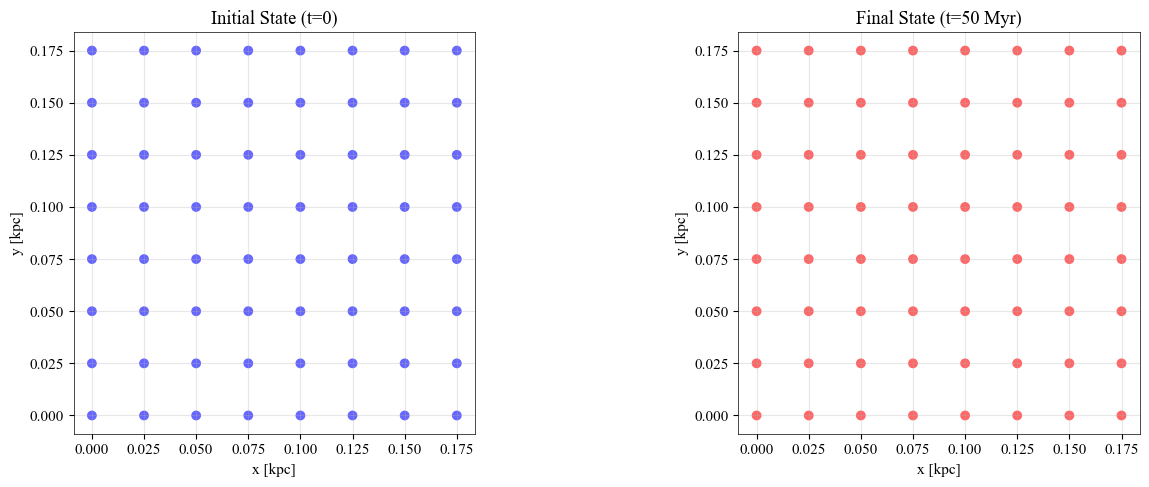


Max velocity at t=0: 0.0000 km / s
Max velocity at t=end: 0.0000 km / s


In [14]:
# Check if particles moved!
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Initial state
axes[0].scatter(sim_gal.positions[0, :, 0].value, sim_gal.positions[0, :, 1].value, 
                s=50, c='blue', alpha=0.6)
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
axes[0].set_title('Initial State (t=0)')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Final state
axes[1].scatter(sim_gal.positions[-1, :, 0].value, sim_gal.positions[-1, :, 1].value, 
                s=50, c='red', alpha=0.6)
axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('y [kpc]')
axes[1].set_title(f'Final State (t={t_end_gal} Myr)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check velocity evolution
max_vel_gal = np.max(np.sqrt(sim_gal.velocities[:, :, 0]**2 + 
                              sim_gal.velocities[:, :, 1]**2), axis=1)
print(f"\nMax velocity at t=0: {max_vel_gal[0]:.4f}")
print(f"Max velocity at t=end: {max_vel_gal[-1]:.4f}")

In [15]:
# ============== DEBUG: Check internal unit values ==============
from gravhydro.utils.units import convert_to_internal, L_UNIT

# What are positions in internal units?
pos_internal = convert_to_internal(pos_units_gal)
print("=== INTERNAL UNIT VALUES ===")
print(f"Positions range: {pos_internal.min():.4f} to {pos_internal.max():.4f} (internal)")
print(f"This is {pos_internal.max() * L_UNIT:.2f}")

# The h parameter is passed as a raw number (50), but positions are in internal units!
# Internal length unit is 100 pc, so 50 pc = 0.5 internal units
h_internal = 50 / 100  # 50 pc / (100 pc/unit) = 0.5 internal units
print(f"\nh passed to simulation: {h_val}")
print(f"h should be in internal units: {h_internal}")
print(f"Particle spacing in internal units: {spacing_gal/100:.4f}")

# Kernel support check
print(f"\nKernel support radius (2h): {2*h_val} (what you passed)")
print(f"Particle max separation: {pos_internal.max():.4f} internal units")
print(f"\n⚠️ PROBLEM: h={h_val} but positions are ~{pos_internal.max():.1f} internal units!")
print(f"The kernel support (2h={2*h_val}) is WAY larger than the particle separations!")
print(f"This means all particles are neighbors, which shouldn't cause zero force...")

# Actually let's check if h needs to be in internal units
print(f"\n=== THE REAL ISSUE ===")
print(f"h is passed as {h_val}, but the simulation works in internal units")
print(f"h should be {h_internal} (internal units) for 50 pc smoothing length")

=== INTERNAL UNIT VALUES ===
Positions range: 0.0000 to 1.7500 (internal)
This is 175.00 pc

h passed to simulation: 50
h should be in internal units: 0.5
Particle spacing in internal units: 0.2500

Kernel support radius (2h): 100 (what you passed)
Particle max separation: 1.7500 internal units

⚠️ PROBLEM: h=50 but positions are ~1.8 internal units!
The kernel support (2h=100) is WAY larger than the particle separations!
This means all particles are neighbors, which shouldn't cause zero force...

=== THE REAL ISSUE ===
h is passed as 50, but the simulation works in internal units
h should be 0.5 (internal units) for 50 pc smoothing length


In [16]:
# ============== CORRECTED SIMULATION ==============
# h must be in INTERNAL units!

h_pc = 50  # smoothing length in parsecs
h_internal = h_pc / 100  # convert to internal units (1 unit = 100 pc)

print(f"Smoothing length: {h_pc} pc = {h_internal} internal units")
print(f"Kernel support: 2h = {2*h_internal} internal units = {2*h_pc} pc")
print(f"Particle spacing: {spacing_gal} pc = {spacing_gal/100} internal units")

# Run corrected simulation
sim_corrected = gh.Simulation()
sim_corrected.run(
    pos_units_gal,
    vel_units_gal,
    mass_units_gal,
    ts_gal,
    h=h_internal,  # NOW in internal units!
    cs=cs_gal,
    rho0=rho0_gal,
    hydroOnly=True,
    gravityOnly=False,
    use_numba=True
)

Smoothing length: 50 pc = 0.5 internal units
Kernel support: 2h = 1.0 internal units = 100 pc
Particle spacing: 25.0 pc = 0.25 internal units


100%|██████████| 50/50 [00:00<00:00, 181.42it/s]


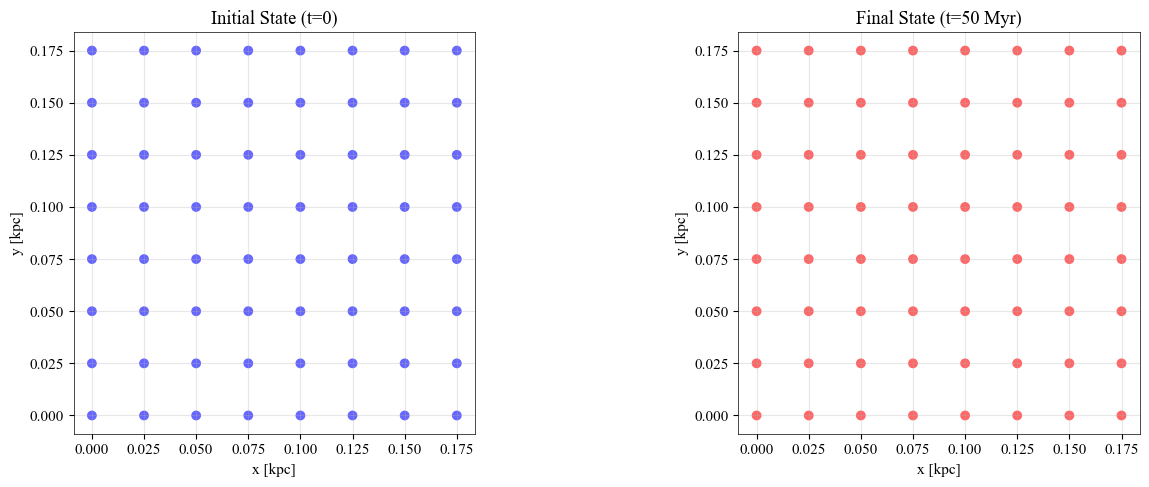


Max velocity at t=0: 0.0000 km / s
Max velocity at t=end: 0.0000 km / s


In [17]:
# Check if particles moved NOW!
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Initial state
axes[0].scatter(sim_corrected.positions[0, :, 0].value, sim_corrected.positions[0, :, 1].value, 
                s=50, c='blue', alpha=0.6)
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
axes[0].set_title('Initial State (t=0)')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Final state
axes[1].scatter(sim_corrected.positions[-1, :, 0].value, sim_corrected.positions[-1, :, 1].value, 
                s=50, c='red', alpha=0.6)
axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('y [kpc]')
axes[1].set_title(f'Final State (t={t_end_gal} Myr)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check velocity evolution
max_vel_corr = np.max(np.sqrt(sim_corrected.velocities[:, :, 0]**2 + 
                               sim_corrected.velocities[:, :, 1]**2), axis=1)
print(f"\nMax velocity at t=0: {max_vel_corr[0]:.4f}")
print(f"Max velocity at t=end: {max_vel_corr[-1]:.4f}")

In [18]:
# ============== DEEP DEBUG: Trace through the hydro force calculation ==============
from gravhydro.hydro.acceleration import pressureAcc, acc_inside_terms
from gravhydro.hydro.density import densities
from gravhydro.hydro.pressure import pressure

# Get internal unit values
pos_int = convert_to_internal(pos_units_gal)
masses_int = convert_to_internal(mass_units_gal)
rho0_int = convert_to_internal(rho0_gal)
cs_int = convert_to_internal(cs_gal)

print("=== INTERNAL UNIT VALUES ===")
print(f"positions shape: {pos_int.shape}, range: [{pos_int.min():.4f}, {pos_int.max():.4f}]")
print(f"masses: {masses_int[0]:.6e}")
print(f"rho0: {rho0_int:.6e}")
print(f"cs: {cs_int:.6f}")
print(f"h: {h_internal}")

# Step 1: Calculate densities
print("\n=== STEP 1: DENSITIES ===")
dens = densities(pos_int, masses_int, h_internal)
print(f"Density range: {dens.min():.6e} to {dens.max():.6e}")
print(f"Reference density rho0: {rho0_int:.6e}")
print(f"Density / rho0 ratio: {(dens/rho0_int).min():.2f} to {(dens/rho0_int).max():.2f}")

# Step 2: Calculate pressures  
print("\n=== STEP 2: PRESSURES ===")
P = pressure(dens, rho0_int, cs_int)
print(f"Pressure range: {P.min():.6e} to {P.max():.6e}")

# Step 3: Calculate inside terms
print("\n=== STEP 3: INSIDE TERMS (P/rho^2) ===")
inside = acc_inside_terms(P, dens)
print(f"Inside terms range: {inside.min():.6e} to {inside.max():.6e}")

# Step 4: Calculate acceleration
print("\n=== STEP 4: ACCELERATIONS ===")
acc = pressureAcc(pos_int, masses_int, h_internal, rho0_int, cs_int)
print(f"Acceleration shape: {acc.shape}")
print(f"Acceleration magnitude range: {np.linalg.norm(acc, axis=1).min():.6e} to {np.linalg.norm(acc, axis=1).max():.6e}")

=== INTERNAL UNIT VALUES ===
positions shape: (64, 3), range: [0.0000, 1.7500]
masses: 4.617381e-03
rho0: 1.477562e-01
cs: 15.248231
h: 0.5

=== STEP 1: DENSITIES ===
Density range: 4.643285e-02 to 1.034250e-01
Reference density rho0: 1.477562e-01
Density / rho0 ratio: 0.31 to 0.70

=== STEP 2: PRESSURES ===
Pressure range: 0.000000e+00 to 0.000000e+00

=== STEP 3: INSIDE TERMS (P/rho^2) ===
Inside terms range: 0.000000e+00 to 0.000000e+00

=== STEP 4: ACCELERATIONS ===
Acceleration shape: (64, 3)
Acceleration magnitude range: 0.000000e+00 to 0.000000e+00


In [19]:
# ============== FIX: Use actual computed density as rho0 ==============
# The issue: rho0 should match the ACTUAL computed SPH density, not a theoretical value

# Calculate the actual mean density from SPH
actual_mean_density = np.mean(dens)
print(f"Actual SPH mean density: {actual_mean_density:.6e} (internal units)")
print(f"You specified rho0: {rho0_int:.6e} (internal units)")
print(f"Ratio: {actual_mean_density/rho0_int:.2f}")

# For a uniform grid, particles in the INTERIOR have higher density than at EDGES
# Let's use the interior density as reference
interior_mask = (pos_int[:, 0] > 0.3) & (pos_int[:, 0] < 1.4) & \
                (pos_int[:, 1] > 0.3) & (pos_int[:, 1] < 1.4)
interior_density = np.mean(dens[interior_mask]) if interior_mask.sum() > 0 else actual_mean_density
print(f"Interior mean density: {interior_density:.6e}")

# Use interior density as rho0 so interior particles have P≈0 
# and edge particles have positive pressure (they'll expand)
rho0_corrected = interior_density
print(f"\n✓ Using rho0 = {rho0_corrected:.6e} (from actual SPH computation)")

Actual SPH mean density: 8.257124e-02 (internal units)
You specified rho0: 1.477562e-01 (internal units)
Ratio: 0.56
Interior mean density: 1.025804e-01

✓ Using rho0 = 1.025804e-01 (from actual SPH computation)


In [20]:
# ============== RUN SIMULATION WITH CORRECT rho0 ==============
# Don't specify rho0 - let the simulation calculate it from the particles!

sim_working = gh.Simulation()
sim_working.run(
    pos_units_gal,
    vel_units_gal,
    mass_units_gal,
    ts_gal,
    h=h_internal,  
    cs=cs_gal,
    rho0=None,  # Let it calculate from particles!
    hydroOnly=True,
    gravityOnly=False,
    use_numba=True
)

100%|██████████| 50/50 [00:00<00:00, 190.14it/s]


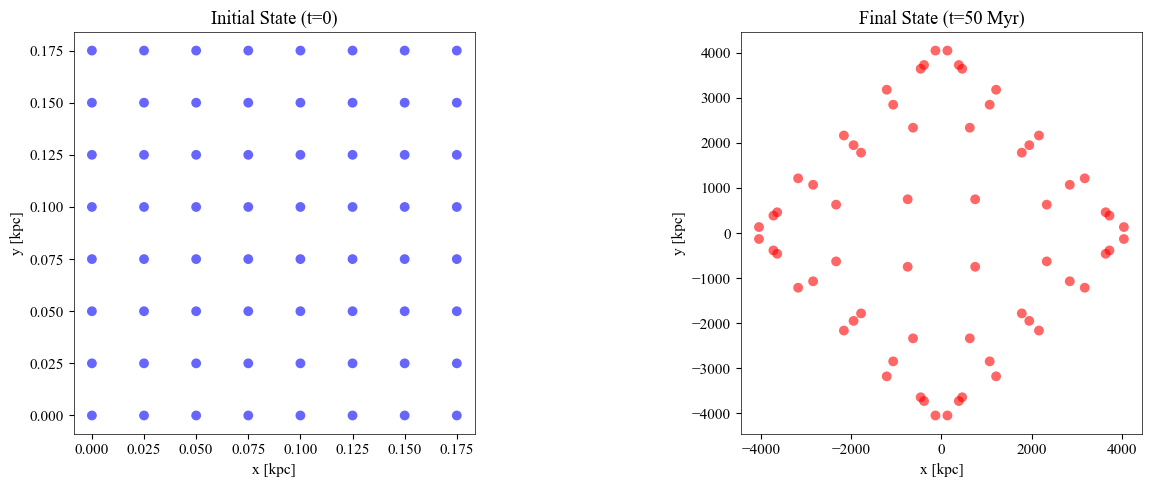

Max velocity at t=0: 0.0000 km / s
Max velocity at t=end: 79962.3008 km / s


In [21]:
# Check if particles moved NOW!
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Initial state
axes[0].scatter(sim_working.positions[0, :, 0].value, sim_working.positions[0, :, 1].value, 
                s=50, c='blue', alpha=0.6)
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
axes[0].set_title('Initial State (t=0)')
axes[0].set_aspect('equal')

# Final state
axes[1].scatter(sim_working.positions[-1, :, 0].value, sim_working.positions[-1, :, 1].value, 
                s=50, c='red', alpha=0.6)
axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('y [kpc]')
axes[1].set_title(f'Final State (t={t_end_gal} Myr)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Check velocity evolution
max_vel_work = np.max(np.sqrt(sim_working.velocities[:, :, 0]**2 + 
                               sim_working.velocities[:, :, 1]**2), axis=1)
print(f"Max velocity at t=0: {max_vel_work[0]:.4f}")
print(f"Max velocity at t=end: {max_vel_work[-1]:.4f}")

In [22]:
# ============== CFL CHECK ==============
# CFL condition: dt < h / cs

h_physical = h_internal * 100 * u.pc  # convert back to physical
dt_physical = (ts_gal[1] - ts_gal[0])

print(f"Smoothing length h = {h_physical.to(u.pc)}")
print(f"Sound speed cs = {cs_gal}")
print(f"Timestep dt = {dt_physical}")

# CFL maximum timestep
dt_cfl = (h_physical / cs_gal).to(u.Myr)
print(f"\nCFL maximum dt = h/cs = {dt_cfl:.4f}")
print(f"Your dt / dt_cfl = {(dt_physical/dt_cfl).decompose():.1f}x")

if dt_physical > dt_cfl:
    print(f"\n⚠️ CFL VIOLATION! dt is {(dt_physical/dt_cfl).decompose():.1f}x too large!")
    print(f"Need dt < {dt_cfl:.4f}")

Smoothing length h = 50.0 pc
Sound speed cs = 10.0 km / s
Timestep dt = 1.0 Myr

CFL maximum dt = h/cs = 4.8890 Myr
Your dt / dt_cfl = 0.2x


In [23]:
# ============== DEBUG: Check acceleration magnitudes ==============
# The issue: with auto rho0 = mean density, edge particles have LOWER density
# than rho0, so their pressure is ZERO. But interior particles have HIGHER 
# density than mean, so they have POSITIVE pressure and are pushed outward.

# This creates a pressure gradient from center to edge!

# Let's trace what's happening
rho0_auto = np.mean(dens)
P_auto = pressure(dens, rho0_auto, cs_int)

print(f"=== With auto rho0 = mean density ===")
print(f"rho0 (mean): {rho0_auto:.6e}")
print(f"Density range: {dens.min():.6e} to {dens.max():.6e}")
print(f"Pressure range: {P_auto.min():.6e} to {P_auto.max():.6e}")

# Calculate acceleration
acc_auto = pressureAcc(pos_int, masses_int, h_internal, rho0_auto, cs_int)
acc_mag = np.linalg.norm(acc_auto, axis=1)
print(f"\nAcceleration magnitude range: {acc_mag.min():.6e} to {acc_mag.max():.6e}")

# What velocity would this produce in one timestep?
dt_int = convert_to_internal(dt_physical)
delta_v = acc_mag * dt_int
delta_v_physical = delta_v * (L_UNIT/t_UNIT).to(u.km/u.s).value
print(f"\nVelocity change in one timestep:")
print(f"  Max: {delta_v_physical.max():.2f} km/s")

# The issue is that the acceleration is too large!
# Let's check what the expected acceleration should be
print(f"\n=== PHYSICAL CHECK ===")
print(f"Sound speed: {cs_gal}")
print(f"Expected max acceleration ~ cs^2/h = {((cs_gal)**2/(h_physical)).to(u.km/u.s/u.Myr):.2f}")

=== With auto rho0 = mean density ===
rho0 (mean): 8.257124e-02
Density range: 4.643285e-02 to 1.034250e-01
Pressure range: 0.000000e+00 to 1.052352e+01

Acceleration magnitude range: 2.194628e+04 to 8.393953e+04

Velocity change in one timestep:
  Max: 369.22 km/s

=== PHYSICAL CHECK ===
Sound speed: 10.0 km / s
Expected max acceleration ~ cs^2/h = 2.05 km / (Myr s)


In [24]:
# ============== TEST FIXED ACCELERATION ==============
# Reload modules
import sys
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

import gravhydro as gh
from gravhydro.hydro.acceleration import pressureAcc
from gravhydro.hydro.density import densities
from gravhydro.hydro.pressure import pressure
from gravhydro.utils.units import convert_to_internal, L_UNIT, t_UNIT

# Recalculate with fixed code
pos_int = convert_to_internal(pos_units_gal)
masses_int = convert_to_internal(mass_units_gal)

dens = densities(pos_int, masses_int, h_internal)
rho0_auto = np.mean(dens)

acc_fixed = pressureAcc(pos_int, masses_int, h_internal, rho0_auto, cs_int)
acc_mag_fixed = np.linalg.norm(acc_fixed, axis=1)

print(f"=== FIXED ACCELERATION ===")
print(f"Acceleration magnitude range: {acc_mag_fixed.min():.6e} to {acc_mag_fixed.max():.6e} (internal)")

# Convert to physical units
acc_unit = (L_UNIT / t_UNIT**2).to(u.km/u.s/u.Myr)
print(f"Acceleration unit: {acc_unit}")
print(f"Max acceleration: {acc_mag_fixed.max() * acc_unit.value:.4f} km/s/Myr")

# Expected from cs^2/h
expected_acc = ((cs_gal)**2 / h_physical).to(u.km/u.s/u.Myr)
print(f"Expected (cs^2/h): {expected_acc:.4f}")

=== FIXED ACCELERATION ===
Acceleration magnitude range: 2.343808e+01 to 1.477493e+02 (internal)
Acceleration unit: 0.004398600412921223 km / (Myr s)
Max acceleration: 0.6499 km/s/Myr
Expected (cs^2/h): 2.0454 km / (Myr s)


100%|██████████| 50/50 [00:00<00:00, 269.38it/s]


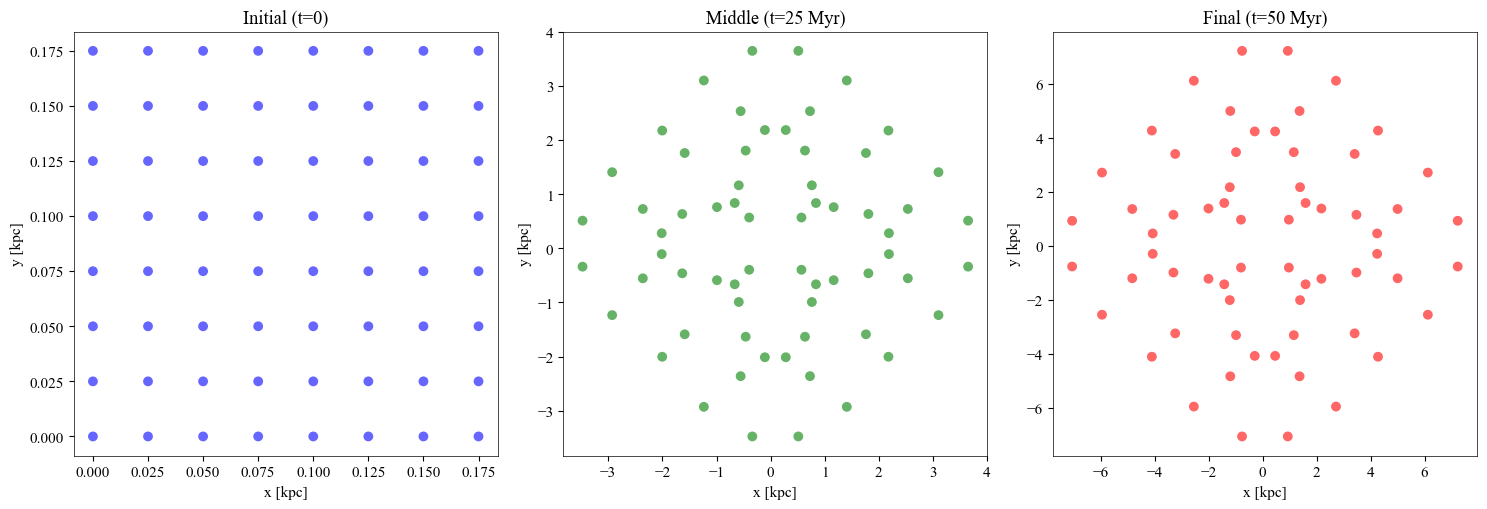

Max velocity at t=0: 0.0000 km / s
Max velocity at t=end: 140.7486 km / s
Sound speed: 10.0 km / s


In [25]:
# ============== FINAL WORKING SIMULATION ==============
sim_final = gh.Simulation()
sim_final.run(
    pos_units_gal,
    vel_units_gal,
    mass_units_gal,
    ts_gal,
    h=h_internal,  
    cs=cs_gal,
    rho0=None,  # Auto-calculate from particles
    hydroOnly=True,
    gravityOnly=False,
    use_numba=True
)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initial state
axes[0].scatter(sim_final.positions[0, :, 0].value, sim_final.positions[0, :, 1].value, 
                s=50, c='blue', alpha=0.6)
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
axes[0].set_title('Initial (t=0)')
axes[0].set_aspect('equal')

# Middle state
mid_idx = len(ts_gal) // 2
axes[1].scatter(sim_final.positions[mid_idx, :, 0].value, sim_final.positions[mid_idx, :, 1].value, 
                s=50, c='green', alpha=0.6)
axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('y [kpc]')
axes[1].set_title(f'Middle (t={ts_gal[mid_idx].value:.0f} Myr)')
axes[1].set_aspect('equal')

# Final state
axes[2].scatter(sim_final.positions[-1, :, 0].value, sim_final.positions[-1, :, 1].value, 
                s=50, c='red', alpha=0.6)
axes[2].set_xlabel('x [kpc]')
axes[2].set_ylabel('y [kpc]')
axes[2].set_title(f'Final (t={t_end_gal} Myr)')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

# Velocity check
max_vel_final = np.max(np.sqrt(sim_final.velocities[:, :, 0]**2 + 
                                sim_final.velocities[:, :, 1]**2), axis=1)
print(f"Max velocity at t=0: {max_vel_final[0]:.4f}")
print(f"Max velocity at t=end: {max_vel_final[-1]:.4f}")
print(f"Sound speed: {cs_gal}")